# **Step2_AI면접관 Agent v2.0**

## **0. 미션**

### 미션③ : 고도화

* 1) 모듈 고도화 : 다음 항목에 대해서 조 상황에 맞게 선택적으로 고도화 합니다.
    * 사전 준비 단계 고도화 : Resume 요약, 전략도출 등 단계 고도화 시도
    * 답변에 대한 평가 고도화 : 평가가 적절한지 피드백 : reflection 노드 추가
    * 질문 생성 고도화 : 전략 별 참조 질문 Vector DB 구성
    * 인터뷰 진행 검토 : 기준에 따라 종료 여부 검토, 추가질문(같은 부문 심화 질문?, 새로운 부문 질문?)
    * 최종 평가 피드백 : 질문과 답변에 대한 최종 평가 보고서 제공

* 2) 웹 화면 연결(Gradio)


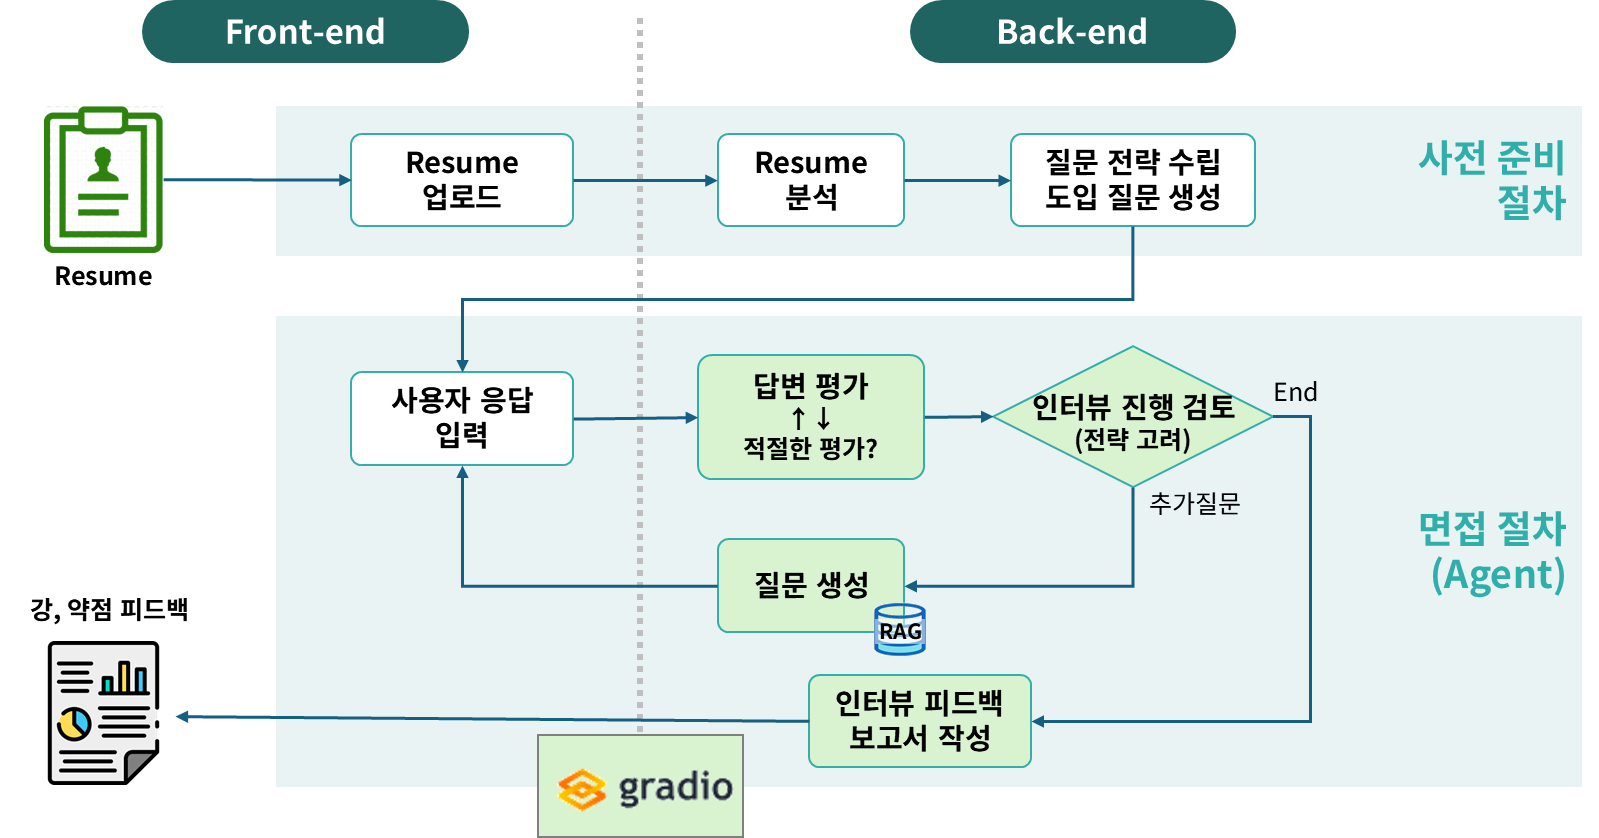

## **1. 환경준비**

### (1) 구글 드라이브

#### 1) 구글 드라이브 폴더 생성
* 새 폴더(project_genai)를 생성하고
* 제공 받은 파일을 업로드

#### 2) 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (2) 라이브러리

#### 1) 필요한 라이브러리 설치

In [ ]:
!pip install -r /content/drive/MyDrive/project_genai/requirements.txt -q
!pip install wikipedia-api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.7/437.7 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

#### 2) 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import os
import openai
import random
import ast
import fitz
from docx import Document

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from typing import Annotated, Literal, Sequence, TypedDict, List, Dict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.output_parsers import CommaSeparatedListOutputParser
from langgraph.graph import StateGraph, END

### (3) OpenAI API Key 확인

In [ ]:
def load_api_keys(filepath="api_key.txt"):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

path = '/content/drive/MyDrive/project_genai/'
# API 키 로드 및 환경변수 설정
load_api_keys(path + 'api_key.txt')
llm=ChatOpenAI(model="gpt-4o-mini")

⚠️ 아래 코드셀은, 실행해서 key가 제대로 보이는지 확인하고 삭제하세요.

In [ ]:
print(os.environ['OPENAI_API_KEY'][:30])

sk-proj-rFBDwtWMLgSipbzOUgDYj2


## **2. 미션③ : 고도화1**

* 미션① 고도화
    * Step1의 코드들을 붙어 넣고, 고도화가 필요하다면 코드를 개선합니다.
    * 개선 권장 부분
        * Resume 분석 : 요약 및 키워드 범위를 정하는 프롬프트 개선
        * 질문 전략 수립 : 3가지 부문 조정하고 질문 전략을 잘 뽑기 위한 프롬프트 개선

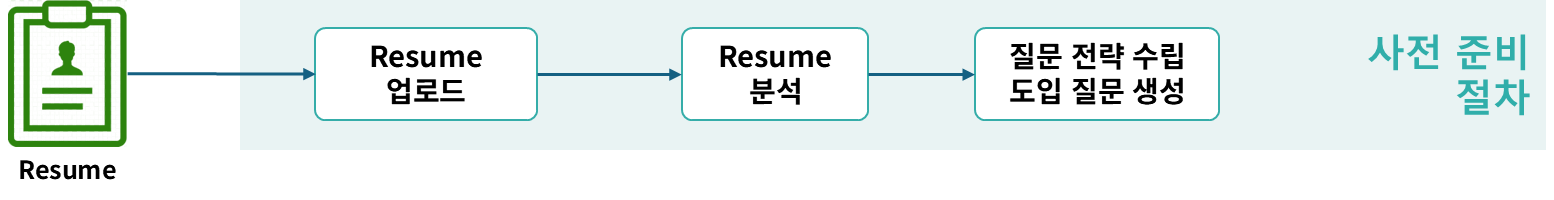

### (1) 파일 입력

In [ ]:
def extract_text_from_file(file_path: str) -> str:
    ext = os.path.splitext(file_path)[1].lower()
    if ext == ".pdf":
        doc = fitz.open(file_path)
        text = "\n".join(page.get_text() for page in doc)
        doc.close()
        return text
    elif ext == ".docx":
        doc = Document(file_path)
        return "\n".join(p.text for p in doc.paragraphs if p.text.strip())
    else:
        raise ValueError("지원하지 않는 파일 형식입니다. PDF 또는 DOCX만 허용됩니다.")


### (2) State 선언

In [ ]:
class InterviewState(TypedDict):
    # 고정 정보
    resume_text: str
    resume_summary: str
    resume_keywords: List[str]
    question_strategy: Dict[str, Dict]

    # 인터뷰 로그
    current_question: str
    current_answer: str
    current_strategy: str
    past_strategy: str
    conversation: List[Dict[str, str]]
    evaluation : List[Dict[str, str]]
    next_step : str

### (3) Resume 분석

In [ ]:
def analyze_resume(state: InterviewState) -> InterviewState:
    resume_text = state.get("resume_text", "")

    if not resume_text:
        raise ValueError("resume_text가 비어 있습니다. 먼저 텍스트를 추출해야 합니다.")

    llm = ChatOpenAI(model="gpt-4o-mini")

    # 요약 프롬프트 구성
    summary_prompt = ChatPromptTemplate.from_template(
        '''당신은 이력서를 바탕으로 인터뷰 질문을 설계하는 AI입니다.
        다음 이력서 및 자기소개서 내용에서 질문을 뽑기 위한 중요한 내용을 10문장 정도로 요약을 해줘(요약시 ** 기호는 사용하지 말것):\n\n{resume_text}'''
    )
    formatted_summary_prompt = summary_prompt.format(resume_text=resume_text)
    summary_response = llm.invoke(formatted_summary_prompt)
    resume_summary = summary_response.content.strip()

    # 키워드 추출 프롬프트 구성
    keyword_prompt = ChatPromptTemplate.from_template(
        '''당신은 이력서를 바탕으로 인터뷰 질문을 설계하는 AI입니다.
        다음 이력서 및 자기소개서내용에서 질문을 뽑기 위한 중요한 핵심 키워드를 5~10개 추출해줘. 도출한 핵심 키워드만 쉼표로 구분해줘:\n\n{resume_text}'''
    )
    formatted_keyword_prompt = keyword_prompt.format(resume_text=resume_text)
    keyword_response = llm.invoke(formatted_keyword_prompt)

    # 원래 형식대로 쉼표로 구분된 키워드를 리스트로 변환
    resume_keywords = [keyword.strip() for keyword in keyword_response.content.split(",")]

    return {
        **state,
        "resume_summary": resume_summary,
        "resume_keywords": resume_keywords,
    }


### (4) 질문 전략 수립

In [ ]:

from typing import Dict
import ast

llm = ChatOpenAI(model_name='gpt-4o-mini', temperature=0)

def generate_question_strategy(state: InterviewState) -> InterviewState:
    resume_summary = state.get("resume_summary", "")
    resume_keywords = ", ".join(state.get("resume_keywords", []))

    prompt = ChatPromptTemplate.from_template("""
당신은 이력서를 바탕으로 인터뷰 질문을 설계하는 AI입니다.
다음 이력서 요약과 키워드를 기반으로, 다음 3가지 질문 부문 별로 질문 방향과 예시 질문 2개를 딕셔너리 형태로 출력해줘.

- 이력서 요약:
{resume_summary}

- 이력서 키워드:
{resume_keywords}

아래 형식을 따라줘:
딕셔너리 형태에서 key는 3가지 질문 부문이야. '경력 및 경험', '동기 및 커뮤니케이션', '논리적 사고'
각 key에 해당하는 value는 딕셔너리 형태로 여기의 key는 2가지로 '질문전략', '예시질문' 이야.
'질문전략'의 value는 각 질문 부문에 대해서, 이력서요약 및 키워드로부터 질문 전략 및 방향을 결정하는 구체적인 문장이야.
'예시질문'의 value는 리스트형태로, 질문전략에 맞는 구체적인 예시 질문 2개 문장이야.

[예시]
{{{{ "경력 및 경험": {{'질문전략' : "지원자의 실무 경험, 기술적 능력 및 프로젝트 관리 경험을 중점적으로 평가하는 방향으로 질문을 구성합니다. 이를 통해 지원자가 과거에 경험한 기술적 도전과 문제 해결 방식, 팀 내의 역할 등을 확인할 수 있습니다.",
'예시질문': ['KT의 AI 연구소에서 인턴으로 근무하며 OCR 기반 문서 처리 시스템을 고도화할 때 겪었던 기술적 난관은 무엇이었고, 이를 어떻게 극복했는지 설명해 주시겠습니까?',
'빅데이터 학생연합에서 프로젝트를 리드했던 경험에 대해 이야기해 주세요. 어떤 과제가 있었고, 팀원들과의 소통 과정에서 어려움은 없었는지 궁금합니다.']}},
"동기 및 커뮤니케이션": ...,
"논리적 사고": ...
}}}}
앞뒤로 ```python ~ ``` 붙이는것은 하지 마.
""")

    llm = ChatOpenAI(model="gpt-4o-mini")
    formatted_prompt = prompt.format(resume_summary=resume_summary, resume_keywords=resume_keywords)
    response = llm.invoke(formatted_prompt)

    # 딕셔너리로 변환
    dict_value = response.content.strip()
    if isinstance(dict_value, str):
        try:
            strategy_dict = ast.literal_eval(dict_value)
        except Exception as e:
            raise ValueError("question_strategy를 딕셔너리로 변환하는 데 실패했습니다.") from e

    return {
        **state,
        "question_strategy": strategy_dict
    }


### (5) 하나로 묶기

In [ ]:
def preProcessing_Interview(file_path: str) -> InterviewState:
    """
    면접 사전 준비 절차를 수행하는 함수입니다.

    Args:
        file_path (str): 이력서 파일 경로

    Returns:
        InterviewState: 면접 상태 정보를 담은 딕셔너리
    """
    # 1. 이력서/자소서에서 텍스트 추출
    resume_text = extract_text_from_file(file_path)

    # 2. 초기 상태에 이력서 텍스트 추가
    state: InterviewState = {
        "resume_text": resume_text,
        "resume_summary": '',
        "resume_keywords": [],
        "question_strategy": {},

        "current_question": '',
        "current_answer": '',
        "current_strategy": '',
        "past_strategy": '',
        "conversation": [],
        "evaluation": [],
        "next_step": ''
    }

    # Resume 분석
    state = analyze_resume(state)

    # 질문 전략 수립
    state = generate_question_strategy(state)

    # 첫번째 질문 생성
    question_strategy = state["question_strategy"]
    selected_strategy = "경력 및 경험"
    example_questions = question_strategy[selected_strategy]["예시질문"]
    selected_question = random.choice(example_questions)

    return {
        **state,
        "current_question": selected_question,
        "current_strategy": selected_strategy,
        "past_strategy": selected_strategy
    }


## **3. 미션③ : 고도화2**

* 미션② 고도화
    * 답변에 대한 평가 고도화
        * 평가가 적절한지 피드백 : reflection 노드 추가
    * 질문 생성 고도화
        * 생성된 질문이 적절한지 피드백 : reflection 노드 추가
        * 전략 별 참조 질문 Vector DB 구성
    * 최종 평가 피드백
        * 질문과 답변에 대한 최종 평가 보고서 제공


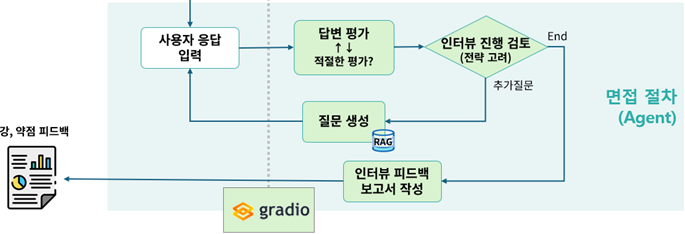

### (1) 답변 입력

In [ ]:
def update_current_answer(state: InterviewState, user_answer: str) -> InterviewState:
    return {
        **state,
        "current_answer": user_answer.strip()
    }


### (2) 답변 평가 : 고도화
* 고도화 제안
    * 평가가 적절한지 피드백 : reflection 노드 추가
    * conversation 저장이 중복되지 않도록 코드 조정

| 항목 | 설명 |
| ---- | ---- |
 목적 | 최근 평가가 적절한지 되돌아보고 판단 (보완 필요 여부 포함)
 입력 | current_question, current_answer, evaluation[-1]
 출력 | 판단 결과: "정상" or "재평가 필요" → state["reflection_status"] 저장
분기 구조 | "정상" → decide_next_step, "재평가 필요" → re_evaluate_answer



In [ ]:
def evaluate_answer(state: InterviewState) -> InterviewState:
    question = state["current_question"]
    answer = state["current_answer"]
    current_topic = state.get("current_strategy", "기타")



    # 프롬프트 구성
    prompt_template = PromptTemplate(
        input_variables=["question", "answer"],
        template="""

당신은 구조화된 기준에 따라 지원자의 면접 답변을 평가하는 AI 평가자입니다.
아래 질문과 답변을 읽고, 각 평가 항목별로 ‘상’, ‘중’, ‘하’ 중 하나를 선택하고 이유를 함께 제시해 주세요.

[질문]
{question}

[답변]
{answer}

아래 다섯 가지 항목에 대해 각 항목별로 ‘상’, ‘중’, ‘하’ 중 하나로 평가해 주세요.
각 등급에 대한 간단한 이유도 함께 적어 주세요.

1. 질문과의 연관성 – 답변이 질문의 핵심 의도에 어느 정도 부합했는지 평가해 주세요.
(예: 질문의 키워드를 잘 파악했는지, 전혀 엉뚱한 방향으로 흐르지 않았는지 등)
상: 질문의 핵심 의도에 정확히 부합하며, 답변이 전반적으로 질문에 집중되어 있음

중: 질문과 관련은 있으나, 핵심 포인트가 부족하거나 방향이 다소 벗어남

하: 질문과 거의 관련이 없거나, 엉뚱한 주제를 중심으로 전개됨



2.답변의 구체성 –  단순한 주장이나 포부보다는 구체적인 경험, 수치, 상황, 역할 등이 포함되어 있는지 확인해 주세요.
(예: "노력했습니다"보다는 "어떤 방식으로 노력했는지"가 드러나야 함)
상: 구체적인 경험, 수치, 상황, 역할 등이 잘 드러나 있음 (ex. 프로젝트 내용, 성과 수치, 팀 내 역할 등)

중: 주장이나 포부는 있지만, 경험이나 사례가 부족하거나 모호함

하: 단순한 추상적 표현만 있고, 경험이나 실제 내용은 거의 없음



3. 답변의 길이 – 답변이 충분한 분량으로 작성되었는지
상: 핵심 내용이 잘 담긴 충분한 길이의 문장 (예: 3~5문장 이상, 정보 밀도 높음)

중: 다소 짧거나 내용이 압축적이긴 하나 요지는 전달됨

하: 한두 문장으로 끝나며, 정보량이 현저히 부족함



4. 답변의 태도 – 글을 통해 진정성, 책임감, 적극성, 성찰적 태도 등이 전달되는지 평가해 주세요.
(예: 실패 경험에 대해 남 탓이 아닌 본인의 개선점을 중심으로 서술했다면 긍정적으로 평가)
상: 진정성, 책임감, 성찰적 태도가 드러나며, 신뢰감 있는 어조

중: 기본적인 태도는 갖추었으나 감정이나 책임감이 덜 전달됨

하: 무성의하거나 회피성 표현이 많고, 책임 회피성 응답이 포함됨


5. 문장 완성도 – 전체 문장이 논리적으로 잘 연결되었는지, 줄임말이나 비문 없이 자연스럽고 읽기 쉬운 문장으로 구성되었는지 확인해 주세요.
상: 문장이 자연스럽고 논리적이며, 비문·줄임말 없이 깔끔하게 연결됨

중: 문장은 전반적으로 이해되나, 일부 어색하거나 비문이 있음

하: 문장이 비정상적이거나 줄임말·은어·축약어가 많아 가독성이 떨어짐


[응답 형식]
{{
  "질문과의 연관성": {{"등급": "상|중|하", "이유": "…"}},
  "답변의 구체성": {{"등급": "상|중|하", "이유": "…"}},
  "답변의 길이": {{"등급": "상|중|하", "이유": "…"}},
  "답변의 태도": {{"등급": "상|중|하", "이유": "…"}},
  "문장 완성도": {{"등급": "상|중|하", "이유": "…"}}
}}
"""
    )

    # prompt_text = prompt_template.format(question=question, answer=answer)
    # response = llm([HumanMessage(content=prompt_text)]).content

    # updated_conversation = state.get("conversation", []) + [
    #     {"question": question, "answer": answer}
    # ]
    # updated_evaluation = state.get("evaluation", []) + [response.strip()]

     # LLM 호출
    prompt_text = prompt_template.format(question=question, answer=answer)
    response = llm([HumanMessage(content=prompt_text)]).content

    # topic 필드를 평가 문자열에 직접 삽입
    response_text = response.strip()
    if response_text.endswith("}"):
        response_text_with_topic = response_text[:-1] + f', "topic": "{current_topic}"' + "}"
    else:
        response_text_with_topic = response_text  # fallback

    # 대화 및 평가 누적
    updated_conversation = state.get("conversation", []) + [{"question": question, "answer": answer}]
    updated_evaluation = state.get("evaluation", []) + [response_text_with_topic]

    return {
        **state,
        "evaluation": updated_evaluation,
        "conversation": updated_conversation
    }


### (3) 인터뷰 진행 검토 : 고도화

* 조건
    * 모든 전략 영역을 한 번 이상 커버했으면 → "end"
    * 전체 질문&답변이 5번 진행되었으면 → "end"  (인터뷰가 너무 길어지는 것 방지)
    * 가장 최근 평가에 "하"가 있다면 → additional_question (현재 전략 유지)
    * 최근 평가가 "상" or "중" → next_strategy (다음 전략으로 전환)

In [ ]:
def decide_next_step(state: InterviewState) -> InterviewState:
    evaluations = state.get("evaluation", [])
    strategy = state.get("question_strategy", {})


    if not evaluations:
        print("🟡 [DEBUG] 평가 없음 → generate")
        return {**state, "next_step": "generate"}

    latest_eval_raw = evaluations[-1]
    try:
        latest_eval = eval(latest_eval_raw)
    except Exception as e:
        print("❌ [DEBUG] 평가 파싱 실패:", e)
        return {**state, "next_step": "end"}

    current_topic = latest_eval.get("topic", None)
    topic_list = list(strategy.keys())

    if current_topic not in topic_list:
        print(f"⚠️ [DEBUG] 현재 topic '{current_topic}'이 topic_list에 없음 → 종료")
        return {**state, "next_step": "end"}

    current_index = topic_list.index(current_topic)
    topic_attempts = [e for e in evaluations if current_topic in e]
    attempt_count = len(topic_attempts)



    # 최근 평가에서 '하' 포함 여부
    low_fields = ["답변의 길이", "답변의 태도", "문장 완성도"]
    is_low = any(
        latest_eval.get(field, {}).get("등급") == "하"
        for field in low_fields
    )

    # # 📌 디버그 출력
    # print(f"\n🧠 [DEBUG] 현재 topic: {current_topic}")
    # print(f"🗂️ [DEBUG] topic_list: {topic_list}")
    # print(f"📍 [DEBUG] current_index: {current_index}")
    # print(f"🔁 [DEBUG] 시도 횟수: {attempt_count}")
    # print(f"⚠️ [DEBUG] 최근 평가 is_low: {is_low}")

    # 결정 로직
    if attempt_count >= 2:
        if current_index + 1 < len(topic_list):
            next_topic = topic_list[current_index + 1]
            state["current_strategy"] = next_topic
            next_step = "generate"
            print(f"➡️ [DEBUG] 최대 2회 도달 → 다음 topic으로 이동: {next_topic}")
        else:
            next_step = "end"
            print("🏁 [DEBUG] 모든 topic 완료 → 인터뷰 종료")

    elif is_low:
        next_step = "generate"
        print("🔁 [DEBUG] 최근 평가에 '하' → 같은 topic에서 재질문")

    else:
        if current_index + 1 < len(topic_list):
            next_topic = topic_list[current_index + 1]
            state["current_strategy"] = next_topic
            next_step = "generate"
            print(f"✅ [DEBUG] 성공 응답 → 다음 topic으로 이동: {next_topic}")
        else:
            next_step = "end"
            print("🏁 [DEBUG] 모든 topic 완료 → 인터뷰 종료")

    return {
        **state,
        "next_step": next_step
    }


### (4) 질문 생성 : 고도화

* 요건
    * 현재 generate_question()은 기존 전략 예시 질문과 최근 답변을 기반으로 심화 질문 생성
    * 여기에 Chroma Vector DB를 추가해서, 유사 질문 3개 정도를 LLM 프롬프트에 참조 정보로 포함
    * 질문은 여전히 LLM이 생성, 유사 질문은 참고로만 사용

In [ ]:
from langchain.document_loaders import CSVLoader
from langchain.text_splitter import TokenTextSplitter
# CSV 파일 로드
path = '/content/drive/MyDrive/project_genai/'
csv_path = path + "interview_questions.csv"
csv_loader = CSVLoader(file_path=csv_path)

documents_csv = csv_loader.load()

# 벡터 DB 정의
embedding = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = Chroma.from_documents(documents_csv, embedding,
                                    persist_directory="chroma_db")

retriever = vectorstore.as_retriever()
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_interview_questions",  # 면접 질문 검색용 함수 이름
    '''Search and return useful example interview questions for job interviews,
    including personal introductions, strengths/weaknesses, teamwork style,
    and reasons for applying.''',  # 설명을 면접 질문 내용에 맞게 수정
)
tools = [retriever_tool]

import wikipediaapi
from langchain.schema import Document
wiki = wikipediaapi.Wikipedia('MyProject/1.0 (your_@email.com)', 'ko')

def create_wiki_retriever_tool_from_question(question: str):
    """
    주어진 질문으로부터 위키 기반 RAG용 retriever tool을 생성하는 함수.
    1. 질문에서 키워드 추출
    2. 키워드별 위키 요약 수집
    3. Document 객체 생성
    4. 임베딩 및 Chroma 벡터 저장소 생성
    5. retriever_tool 반환
    """

    # ✅ 키워드 추출
    extract_prompt = f"""
    아래 자기소개서 요약에서 핵심적인 키워드를 추출해 주세요.
    너무 일반적이거나 모호한 단어는 피하고, 자기소개서 요약 핵심 내용을 나타내면서도 이 자기소개소만의 특징을 보여주는 회소성 있는 키워드 단 10개만 뽑아주세요.
    각 키워드는 단어 한 개로만 구성되어야 합니다.

    자기소개서 요약: {question}

    추출된 키워드 (쉼표로 구분된 리스트 형식으로): 예) 키워드1, 키워드2, 키워드3, 키워드4, 키워드5, 키워드6, 키워드7, 키워드8, 키워드9, 키워드10
    """
    response = llm([HumanMessage(content=extract_prompt)]).content.strip()
    keywords = [kw.strip() for kw in response.split(',')]

    # ✅ 위키 요약 수집
    summaries = []
    for keyword in keywords:
        page = wiki.page(keyword)
        if page.exists():
            summaries.append(f"[{keyword}]\n{page.text}")  # 길이 제한

    if not summaries:
        raise ValueError("관련된 위키피디아 문서를 찾을 수 없습니다.")

    combined_text = "\n\n".join(summaries)

    # ✅ Document로 변환
    documents_wiki = [Document(page_content=combined_text, metadata={})]

    # ✅ 임베딩 및 벡터 저장소 생성
    embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
    vectorstore = Chroma.from_documents(documents_wiki, embedding_model, persist_directory="chroma_db_wiki")
    retriever = vectorstore.as_retriever()

    # ✅ retriever tool 생성
    retriever_tool = create_retriever_tool(
        retriever,
        "retrieve_interview_knowledge",  # 유의미한 툴 이름
        '''Retrieve background knowledge or explanations related to a given interview question
        using Wikipedia summaries. Useful for generating deeper follow-up questions or evaluating answers.'''
    )

    return retriever_tool
def truncate_text(text: str, max_tokens: int = 1000) -> str:
    splitter = TokenTextSplitter(chunk_size=max_tokens, chunk_overlap=0)
    chunks = splitter.split_text(text)
    return chunks[0] if chunks else ""

def generate_question(state: InterviewState) -> InterviewState:
    summary = state["resume_summary"]
    keywords = ", ".join(state["resume_keywords"])
    strategy = state["current_strategy"]
    strategy_info = state["question_strategy"][strategy]
    past_strategy = state["past_strategy"]
    last_question = state["current_question"]
    last_answer = state["current_answer"]
    last_evaluation = state["evaluation"]

    # ✅ 1. 검색 쿼리 구성
    query = f"면접 질문 예시 for: {summary}, {keywords}, 전략: {strategy_info.get('question_direction', '')}"

    # ✅ 2. 유사 질문 검색 (이력 기반)
    retrieved_docs_resume = retriever_tool.invoke(query)
    context_resume_raw = "\n".join([doc.page_content for doc in retrieved_docs_resume[:3]]) \
        if isinstance(retrieved_docs_resume, list) else str(retrieved_docs_resume)
    context_resume = truncate_text(context_resume_raw, max_tokens=1000)

    # ✅ 3. Wikipedia 기반 배경지식 retriever tool 생성 및 검색
    wiki_query = summary
    retriever_tool_wiki = create_wiki_retriever_tool_from_question(wiki_query)
    retrieved_docs_wiki = retriever_tool_wiki.invoke(wiki_query)
    context_wiki_raw = "\n".join([doc.page_content for doc in retrieved_docs_wiki[:2]]) \
        if isinstance(retrieved_docs_wiki, list) else str(retrieved_docs_wiki)
    context_wiki = truncate_text(context_wiki_raw, max_tokens=1000)

    # ✅ 4. 전략 비교 및 모드 설정
    same_strategy = (strategy == past_strategy)
    mode = "심화" if same_strategy else "전략전환"

    # ✅ 5. 프롬프트 템플릿 정의
    prompt = PromptTemplate(
        input_variables=[
            "summary", "keywords", "strategy", "past_strategy",
            "direction", "question", "answer", "evaluation",
            "context_resume", "context_wiki", "mode"
        ],
        template="""
당신은 인터뷰어 역할을 맡은 AI입니다.
아래의 이력 정보, 직전 인터뷰 기록, 그리고 검색된 면접 질문 및 배경 지식을 참고하여 다음 질문을 생성하세요.

[이력서 요약]
{summary}

[주요 키워드]
{keywords}

[현재 질문 전략: {strategy}]
[이전 질문 전략: {past_strategy}]
질문 방향성: {direction}

[직전 질문]
{question}

[지원자 답변]
{answer}

[답변 평가]
{evaluation}

[검색된 유사 질문 예시]
{context_resume}

[관련 배경 지식 (Wikipedia)]
{context_wiki}

[질문 생성 모드]
{mode}

- mode가 '심화'인 경우: 직전 질문에 대한 심화 질문을 생성합니다. (답변에서 명확하지 않거나 부족한 부분을 파고들어 주세요.)
- mode가 '전략전환'인 경우: 새로운 전략({strategy})에 맞는 주제를 중심으로, 지원자의 사고력이나 기술적 깊이를 평가할 수 있는 새로운 질문을 생성합니다.

[생성 조건]
질문은 한 문장으로 명확하게 작성해 주세요.
"""
    )

    # ✅ 6. LLM 호출
    prompt_text = prompt.format(
        summary=summary,
        keywords=keywords,
        strategy=strategy,
        past_strategy=past_strategy,
        direction=strategy_info.get("question_direction", ""),
        question=last_question,
        answer=last_answer,
        evaluation=str(last_evaluation),
        context_resume=context_resume,
        context_wiki=context_wiki,
        mode=mode
    )

    response = llm([HumanMessage(content=prompt_text)])


    return {
        **state,
        "current_question": response.content.strip(),
        "current_answer": "",
        "past_strategy": strategy
    }

<ipython-input-14-ed3d7b1da41d>:11: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding = OpenAIEmbeddings(model="text-embedding-3-small")


### (5) 인터뷰 피드백 보고서 : 고도화


* 제안
    * 전략별 요약 : 각 전략 영역별로 답변 스타일, 강점/약점 정리
    * 종합 피드백 : 전체 인터뷰의 인상, 강점, 보완점
    * 형식 : 구조화된 텍스트 (분야별 블록 + 전체 종합 평가)
* 입력으로 활용할 요소
    * state["conversation"]       # 질문/답변 리스트
    * state["evaluation"]         # 질문별 평가 (연관성, 구체성)
    * state["question_strategy"]  # 전략 분류용

In [ ]:
import ast
from langchain.schema import HumanMessage

def summarize_interview(state: InterviewState) -> InterviewState:
    report = "\n📝 인터뷰 종료 리포트\n"
    report += "=" * 40 + "\n"

    conversation = state.get("conversation", [])
    evaluations = state.get("evaluation", [])

    for i, (entry, raw_eval) in enumerate(zip(conversation, evaluations)):
        report += '\n' + "-" * 30 + "\n"
        report += f"[📌 질문 내용 {i + 1}] {entry['question']}\n"
        report += f"[💬 답변 요약 {i + 1}] {entry['answer']}\n"

        try:
            eval_data = ast.literal_eval(raw_eval)
        except Exception as e:
            report += f"⚠️ 평가 파싱 실패: {e}\n"
            continue

        topic = eval_data.get("topic", "알 수 없음")
        report += f"[📁 주제] {topic}\n"
        report += "[📊 평가 결과]\n"
        report += "\n"
        per_question_summary = []
        emoji_map = {"상": "🟢", "중": "🟡", "하": "🔴"}

        for key in ["질문과의 연관성", "답변의 구체성", "답변의 길이", "답변의 태도", "문장 완성도"]:
            if key in eval_data:
                등급 = eval_data[key].get("등급", "N/A")
                이유 = eval_data[key].get("이유", "")
                표시 = f"{등급}{emoji_map.get(등급, '')}"
                report += f" - {key}: {등급} ({이유})\n"
                per_question_summary.append(f"- {key}: {등급} ({이유})")

        # GPT를 통해 per-question 피드백 생성
        eval_summary_text = "\n".join(per_question_summary)
        prompt = f"""
당신은 인사 전문가입니다. 아래는 어떤 지원자가 면접 질문에 대해 답변한 내용을 평가한 결과입니다.

이 평가 내용을 바탕으로, 해당 답변의 강점, 약점, 그리고 개선을 위한 권고사항을 각각 한두 문장씩 간결하게 작성해 주세요.

[평가 내용]
{eval_summary_text}

[응답 형식 예시]
강점: …
약점: …
권고사항: …
"""
        gpt_feedback = llm([HumanMessage(content=prompt)]).content.strip()
        report += "\n[피드백]\n"
        report += gpt_feedback + "\n"

    report += "\n✅ 인터뷰를 마쳤습니다.\n"

    # 최종 리포트 출력
    print(report)

    state["resume_text"] = report  # 기존 resume_text를 리포트로 교체
    return state  # 상태 반환


### (6) 면접 Agent

In [ ]:
# 분기 판단 함수
def route_next(state: InterviewState) -> Literal["generate", "summarize"]:
    return "summarize" if state["next_step"] == "end" else "generate"

# 그래프 정의 시작
builder = StateGraph(InterviewState)

# 노드 추가
builder.add_node("evaluate", evaluate_answer)
builder.add_node("decide", decide_next_step)
builder.add_node("generate", generate_question)
builder.add_node("summarize", summarize_interview)

# 노드 연결
builder.set_entry_point("evaluate")
builder.add_edge("evaluate", "decide")
builder.add_conditional_edges("decide", route_next)
builder.add_edge("generate", END)      # 루프
builder.add_edge("summarize", END)            # 종료

# 컴파일
graph = builder.compile()

## **4. 시스템 실행**

미션3에서 수행한 결과를 통합 테스트 해 봅시다.

### (1) 인터뷰 사전준비 작업

In [ ]:
# 파일 입력
file_path = path + 'Resume_sample.pdf'
state = preProcessing_Interview(file_path)
state

{'resume_text': '<이력서> \n홍길동 (Gil-dong Hong) \n이메일: gildong.hong@example.com \n전화번호: 010-1234-5678 \n학력 \n- 한국대학교 전기정보공학부 학사 (2018.03 ~ 2022.02) \n  GPA: 3.91 / 4.3, 전공과목: 머신러닝, 데이터마이닝, 신호처리 \n경력 \n- KT, AI 연구소 인턴 (2021.07 ~ 2021.12) \n  • OCR 기반 문서 처리 시스템 고도화 \n  • Tesseract + 딥러닝 후처리 파이프라인 설계 \n  • 사내 법률문서 정제 정확도 12% 개선 \n- 빅데이터 학생연합 (BDSA) 기술부장 (2020.03 ~ 2021.02) \n  • Python 기반 크롤러 및 Flask API 개발 \n  • 공공데이터 기반 부동산 가격 예측 프로젝트 리드 \n프로젝트 \n- AI 면접관 시스템 개발 (졸업 과제) \n  • OpenAI GPT + Streamlit + FAISS 기반 질문-응답 시스템 구현 \n  • 이력서 기반 질문 자동 생성 + 답변 피드백 제공 \n- 딥러닝 기반 교통량 예측 (교과목 프로젝트) \n  • LSTM 기반 모델 + 서울시 교통데이터 \n  • MAE 15% 이하로 개선 \n기술 스택 \n- Python, PyTorch, TensorFlow, OpenCV \n- MySQL, MongoDB, Git, Docker \n\n- 영어 (TOEIC 915, 영어면접 가능) \n수상 및 자격 \n- SKT Big Data Challenge 2021 장려상 \n- 정보처리기사 (2022.05 취득) \n기타 \n- Github: github.com/gildong-ai \n- 블로그: blog.naver.com/gildong_dev \n \n \n\n<자기소개서> \n1. 본인 성격의 강/약점에 대해서 실제 사례를 포함하여 작성해 주세요. \n무엇인가 한번 빠져들면 해결하거나 성취할 때까지 모든 열정/노력을 쏟아붓는 성격으

### (2) Agent 실행

In [ ]:
# 사용자 응답 루프
while True:
    print("\n[질문]")
    print(state["current_question"])

    state["current_answer"] = input("\n[답변 입력]:\n")

    # 그래프 실행: 평가 → 판단 → 다음 질문 생성 or 종료
    state = graph.invoke(state)

    if state["next_step"] == "end":
        break



[질문]
KT의 AI 연구소에서 근무하던 동안, 프로젝트에서 맡은 구체적인 역할과 성과에 대해 설명해 주실 수 있나요?

[답변 입력]:
아니


<ipython-input-12-f976d186c56f>:92: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm([HumanMessage(content=prompt_text)]).content


🔁 [DEBUG] 최근 평가에 '하' → 같은 topic에서 재질문

[질문]
KT의 AI 연구소에서 OCR 기반 문서 처리 시스템을 개선하는 과정에서 직면했던 가장 큰 도전 과제는 무엇이었으며, 이를 어떻게 해결했는지 구체적으로 설명해 주실 수 있나요?

[답변 입력]:
ㅇㅇ
➡️ [DEBUG] 최대 2회 도달 → 다음 topic으로 이동: 동기 및 커뮤니케이션

[질문]
최근에 관심 있게 본 머신러닝 기술이나 산업 동향은 무엇이며, 그 기술이 실제로 어떻게 활용될 수 있을지에 대한 당신의 생각을 말씀해 주실 수 있나요?

[답변 입력]:
네, 최근 관심 있게 본 머신러닝 기술은 Multimodal LLM (다중모달 대형 언어 모델) 입니다. 대표적으로 OpenAI의 GPT-4o, Google DeepMind의 Gemini, Meta의 ImageBind 등이 있고, 특히 텍스트, 음성, 이미지, 비디오, 센서 데이터를 통합 처리하는 기술들이 빠르게 진화하고 있습니다.  ✔ 산업 동향 관점에서 주목 이유 기존 LLM이 텍스트만 처리하던 한계를 넘어, 사용자의 상황(Context)과 실시간 데이터를 더욱 풍부하게 이해  검색, Q&A, 상담뿐 아니라 제조, 헬스케어, 리테일, 금융 등 실세계 데이터를 인식·해석·결정하는 AI 시스템으로 확장 가능
✅ [DEBUG] 성공 응답 → 다음 topic으로 이동: 논리적 사고

[질문]
최근에 진행한 프로젝트 중에서 가장 도전적이었던 경험은 무엇이었으며, 그 과정에서 어떤 문제를 해결하기 위해 어떤 접근 방식을 사용했는지 구체적으로 설명해 주실 수 있나요?

[답변 입력]:
네, 최근 관심 있게 본 머신러닝 기술은 Multimodal LLM (다중모달 대형 언어 모델) 입니다. 대표적으로 OpenAI의 GPT-4o, Google DeepMind의 Gemini, Meta의 ImageBind 등이 있고, 특히 텍스트, 음성, 이미지, 비디오, 센서 데이터를 통합 처리하는 기술들이 빠르게 진화하고 있습니다.  ✔ 산업 동향 관